**AIRBNB RIO DE JANEIRO**

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

In [29]:
# import data set
df = pd.read_csv('C:/Users/zanin/OneDrive/Área de Trabalho/airbnbrj/listingsrj.csv')
df_cal = pd.read_csv('C:/Users/zanin/OneDrive/Área de Trabalho/airbnbrj/calendar.csv')

# Identify the numer of rows and columns in the dataset

for data in [df, df_cal]:
    print(data.shape)


(26366, 75)
(9623164, 7)


In [30]:
# Explore the data set and identify data type
for data in [df, df_cal]:
    display(data.head(3))

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,53344884,https://www.airbnb.com/rooms/53344884,20220921172238,2022-09-22,city scrape,Suntuoso apartamento em Copacabana posto 6,suntuoso apartamento de frente para o mar <br ...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,431412286,...,NaN,NaN,NaN,NaN,t,10,8,2,0,NaN
1,7801456,https://www.airbnb.com/rooms/7801456,20220921172238,2022-09-22,city scrape,Ipanema Vieira Souto - Linda Vista,Flat luxuoso com a melhor localização do Rio d...,"Ipanema é considerado o berço do rio, cheio de...",https://a0.muscache.com/pictures/99276394/dc9c...,40650139,...,NaN,NaN,NaN,NaN,t,5,5,0,0,NaN
2,14333905,https://www.airbnb.com/rooms/14333905,20220921172238,2022-09-22,city scrape,Casa compartilhada,"A 15 min. do complexo esportivo de Deodoro, Ca...",NaN,https://a0.muscache.com/pictures/15235501-16c4...,87749071,...,NaN,NaN,NaN,NaN,t,1,1,0,0,NaN


,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,53344884,2022-09-22,t,"$3,500.00","$3,500.00",3.0,365.0
1,53344884,2022-09-23,t,"$3,500.00","$3,500.00",3.0,365.0
2,53344884,2022-09-24,t,"$3,500.00","$3,500.00",3.0,365.0


In [31]:
# columns will all value as NaN(null) is useless to our analysis and can't be filled with any reference value in the column.
# Removing the columns which has all values NaN(null).
df.dropna(axis=1, how='all', inplace=True)
df.shape

(26366, 71)

Variables of interest: Price or Price per accomodation?



In [32]:
# remove money ($) sign and convert to float
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)
df['price'].fillna(df['price'].median(), inplace = True)


In [33]:
# removing outliers in price to better analize and visualize the data.
cols = ['price'] 

Q1 = df[cols].quantile(0.25)
Q3 = df[cols].quantile(0.75)
IQR = Q3 - Q1

df = df[~((df[cols] < (Q1 - 1.5 * IQR)) |(df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

<AxesSubplot: xlabel='price'>

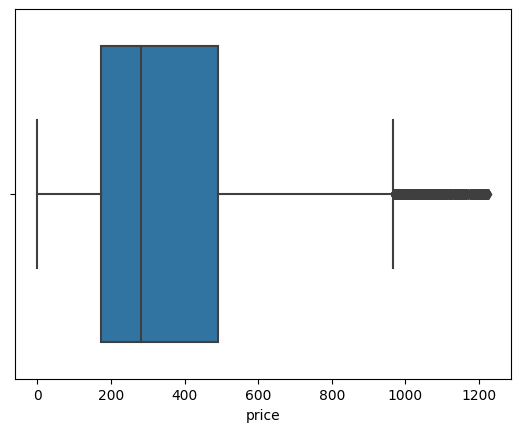

In [34]:
#showing box plot without the outliers
sns.boxplot(data=df, x='price')

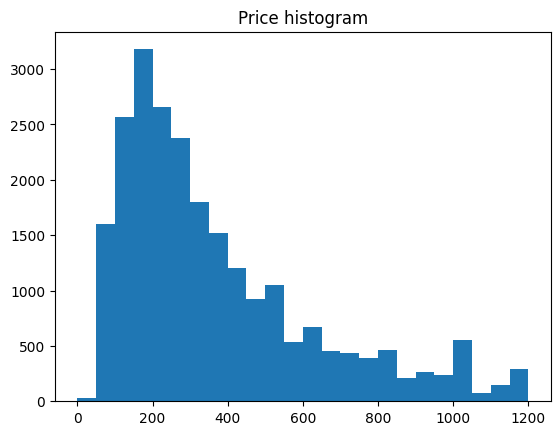

In [35]:
# price histogram 

#sns.histplot(df['price'], kde=True)
bins = np.arange(0, df['price'].max(),50)
plt.hist(data= df, x='price', bins=bins)
plt.title('Price histogram')
plt.show()

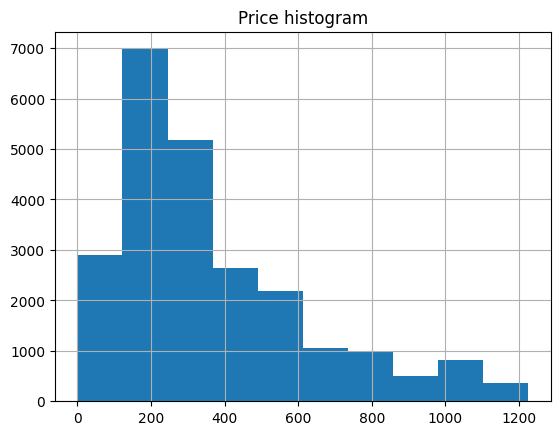

In [36]:
df['price'].hist()
plt.title('Price histogram')
plt.show()

In [37]:
# create the variable price oer accomodate
df['ppa'] = df['price']/df['accommodates']

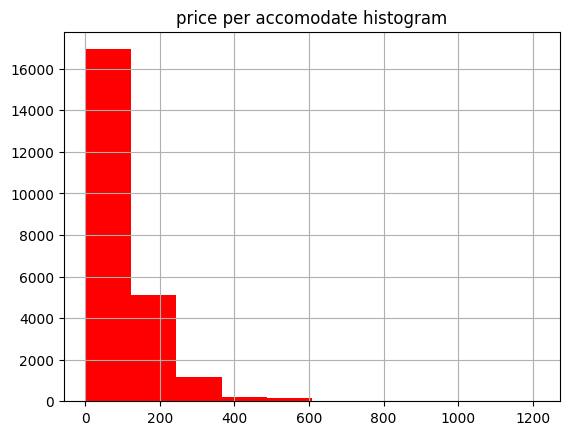

In [38]:
df['ppa'].hist(color='red')
plt.title('price per accomodate histogram')
plt.show()

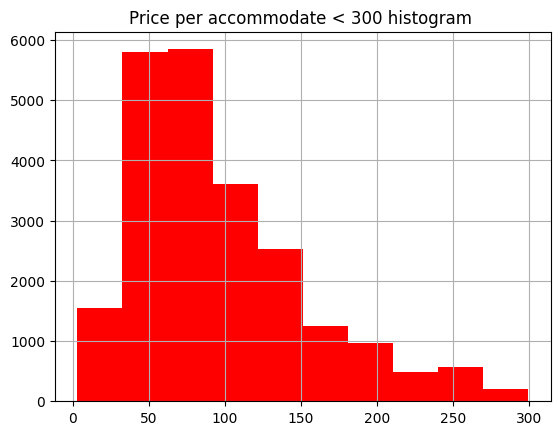

In [39]:
# price per accommodate histogram, considering only values under 300
df[df['ppa']<300]['ppa'].hist(color='red')
plt.title('Price per accommodate < 300 histogram ')
plt.show()

**Data Preparation - Listing dataset (df)**

In order to analyse the property size, we need to consider the property type, room type and badrooms features from data set.

We will further explore the above said feature and create a new dataframe.



In [40]:
# Fill NaN values with ffill/bfill since it is an object type and can't be interpreted with numerical methods to ffilna

df['host_response_rate'].fillna(method='backfill', inplace=True)
df['host_acceptance_rate'].fillna(method='backfill', inplace=True)
df['host_response_time'].fillna(method='backfill', inplace=True)

# Remove %sign and conver the data type to int

df['host_response_rate'] = (df['host_response_rate'].str[:-1].astype(int))
df['host_acceptance_rate'] = (df['host_acceptance_rate'].str[:-1].astype(int))

In [41]:
# Accordanly with summary of df, bathrooms was deleted because had all values NaN(null), but the correct information was placed in bethrooms_text that was 'object' type,
# for that we will rename the column bethrooms_text to bethrooms to better visualization, and than converte only the numbers to float

df.rename(columns={'bathrooms_text' : 'bathrooms'}, inplace=True)
df['bathrooms'] = df['bathrooms'].str.extract('(\d+)').astype(float)

df.bathrooms.head(3)

2    1.0
4    1.0
5    1.0
Name: bathrooms, dtype: float64

As per summary of df, bathrooms, bedrooms and bed columns have different numbers of rows with null values, so it will be better to drop those rows to avoid any little effect of bias, or missleading results.
 
 34  bathrooms                                     26289 non-null  float64

 35  bedrooms                                      25055 non-null  float64
 
 36  beds                                          26130 non-null  float64

In [42]:
# drop na rows in bathrooms, bedrooms and beds since they have differente numbers of rows with NaN(null) values
df.dropna(axis=0, subset=['bathrooms', 'bedrooms', 'beds'], inplace=True)

# Creating a new dataframe with bathrooms, bedrooms and beds.
df_rooms = df[['bathrooms', 'bedrooms', 'beds']]

# Converting the data type from string to integer
for room in df_rooms:
    df_rooms[room].astype(int)

#Assigning the converted values from df_rooms to the df_list dataframe
df[['bathrooms', 'bedrooms', 'beds']] = df_rooms[['bathrooms', 'bedrooms', 'beds']]


In [43]:

# Lets fill na with median values for reviews columns
#The review data distribution above show that the data is highly skewed to left
#To avoid bias in result due to skewness we chose mean to fill na instead of other methods 
for feature in ["review_scores_rating", "review_scores_accuracy", "review_scores_cleanliness", 
                "review_scores_checkin", "review_scores_communication", "review_scores_location", 
                "review_scores_value", "reviews_per_month"]:
    df[feature].fillna(df[feature].mean(), inplace = True)


**Numerical Features**

In [44]:
# select the numerical features 
df_int = df.select_dtypes(include=['float64', 'int64', 'int32'])

# add categorical columns to df_int 
df_int[['superhost', 'room_type', 'neighbourhood_cleansed', 'property_type', 'host_response_time']] = df[['host_is_superhost', 'room_type', 'neighbourhood_cleansed', 'property_type', 'host_response_time']]

df_int.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 22153 entries, 2 to 26365
Data columns (total 47 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            22153 non-null  int64  
 1   scrape_id                                     22153 non-null  int64  
 2   host_id                                       22153 non-null  int64  
 3   host_response_rate                            22153 non-null  int32  
 4   host_acceptance_rate                          22153 non-null  int32  
 5   host_listings_count                           22151 non-null  float64
 6   host_total_listings_count                     22151 non-null  float64
 7   latitude                                      22153 non-null  float64
 8   longitude                                     22153 non-null  float64
 9   accommodates                                  22153 non-null 

In [45]:
#Handle Categorical Variable

cleanup_nums = {'superhost': {'t':1, 'f': 2},
'room_type': {'Entire home/apt': 1, 'private room': 2, 'shared room': 3}}
df_int_copy = df_int
df_int_copy = df_int_copy.replace(cleanup_nums)

#neighbourhood_cleansed, property_type, host_response_time 
df_int_dummies = pd.get_dummies(df_int_copy)


 

Data Preparation - Calendar data - df_cal

In [46]:
# Extract month from dates column

df_cal['month'] = df_cal.date.apply(lambda value: value.split('-')[1])
df_cal['month'] = df_cal['month'].replace({
    '01': 'Jan',
    '02': 'Feb',
    '03': 'Mar',
    '04': 'Apr',
    '05': 'May',
    '06': 'Jun',
    '07': 'Jul',
    '08': 'Aug',
    '09': 'Sep',
    '10': 'Oct',
    '11': 'Nov',
    '12': 'Dec'
})

# Removing adjusted_price column and using only price, to better formart the model, and trying to avoid confusions
# Remove special characters $ from price column and convert to float 
# Drop rows with NaN (null) value in price column, as we have enough rows of data to gain some confidance

df_cal.drop(axis=1, labels=['adjusted_price'], inplace=True)
df_cal.dropna(axis = 0, subset = ["price"], inplace = True)
df_cal["price"] = df_cal["price"].map(lambda x: x.replace("$",'').replace(",",''), na_action = 'ignore').astype(float)

df_cal.head()

,listing_id,date,available,price,minimum_nights,maximum_nights,month
0,53344884,2022-09-22,t,3500.0,3.0,365.0,Sep
1,53344884,2022-09-23,t,3500.0,3.0,365.0,Sep
2,53344884,2022-09-24,t,3500.0,3.0,365.0,Sep
3,53344884,2022-09-25,t,3500.0,3.0,365.0,Sep
4,53344884,2022-09-26,t,3500.0,3.0,365.0,Sep


In [47]:
#Romoving columns that have NaN (null)
df_int_dummies.dropna(axis=1, how='any', inplace=True)

**Model to predict princing**

MAE from RandomForestRegressor(random_state=0):1.070707192296117
MAE from LinearRegression():152.24803274497754


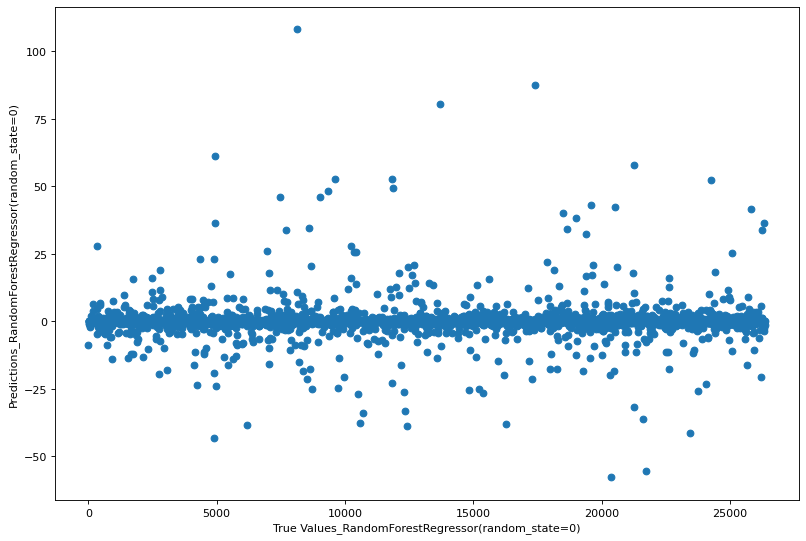

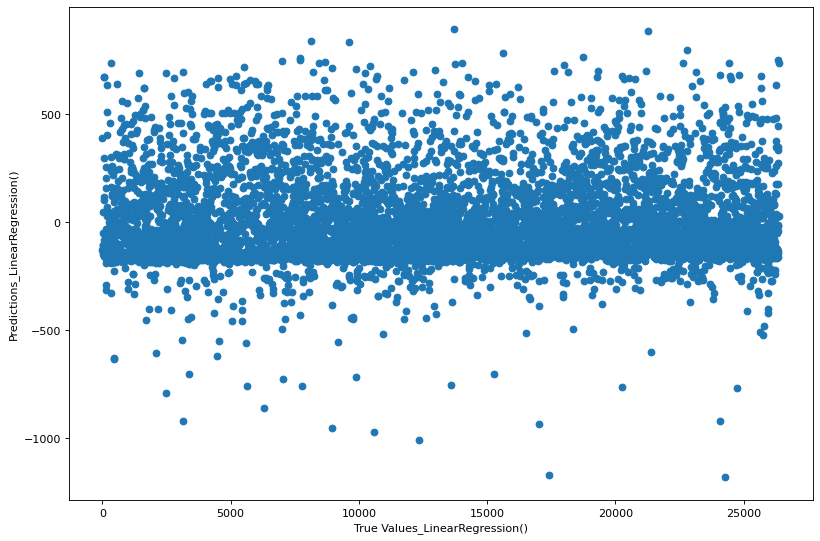

In [48]:
#Assign target y variable and features X variable
y = df_int_dummies.price

X = df_int_dummies.drop(labels = ["price"], axis = 1)

#split test and train dataset from X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)


#We will create a function to fit the model and evaluate
def model_evaluate(model, x_train, y_train, x_test, y_test):
    '''Input:
    model : define prediction algorithm that we want to apply
    x_train : training dataset with input features
    y_test: training data series for target variable
    x_test: validation dataset with input features
    y_test: validation data series for target variable
    
    1.) fit the model to training data set
    2.) predict the target variable for the validation data set
    3.) compare and evaluate the predicted target variable and actual target variable for the validation data set
    
    Output:
    1.) Mean absolute error for each model applied
    2.) scatter plot for the difference between actual and predicted target variable of the validation data set
    '''
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    mae = mean_absolute_error(y_test, pred)
    print("MAE from {0}:{1}".format(model, mae))
    fig = plt.figure(figsize=(12, 8), dpi=80)
    ax1 = fig.add_subplot(111)
    lines = plt.plot(y_test - pred,marker='o',linestyle='')
    ax1.set_xlabel('True Values_{}'.format(model))
    ax1.set_ylabel('Predictions_{}'.format(model))

#Random Forest Regressor
model_rf = RandomForestRegressor(n_estimators=100, random_state=0)    
model_evaluate(model_rf, X_train, y_train, X_test, y_test)

#Linear Regression
model_lr = LinearRegression()
model_evaluate(model_lr, X_train, y_train, X_test, y_test)

Random forest Regressor has a MAE of 1.07 comparing to Linear Regression MAE value 152.24, which helps us to understand that Random forest model is performing way better than Linear Regression.

In [49]:
#Analyse the listing dataset
#Count the number of total number of entries for each type in room_type feature
df_int.groupby(['room_type']).count()

,id,scrape_id,host_id,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,...,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,ppa,superhost,neighbourhood_cleansed,property_type,host_response_time
room_type,,,,,,,,,,,,,,,,,,,,,
Entire home/apt,16424,16424,16424,16424,16424,16422,16422,16424,16424,16424,...,16424,16424,16424,16424,16424,16424,16424,16424,16424,16424
Hotel room,40,40,40,40,40,40,40,40,40,40,...,40,40,40,40,40,40,39,40,40,40
Private room,5216,5216,5216,5216,5216,5216,5216,5216,5216,5216,...,5216,5216,5216,5216,5216,5216,5216,5216,5216,5216
Shared room,473,473,473,473,473,473,473,473,473,473,...,473,473,473,473,473,473,473,473,473,473


C:\Users\zanin\AppData\Local\Temp\ipykernel_18812\2664079402.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_int[df_int.room_type == 'Private room']['price'],
C:\Users\zanin\AppData\Local\Temp\ipykernel_18812\2664079402.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_int[df_int.ro

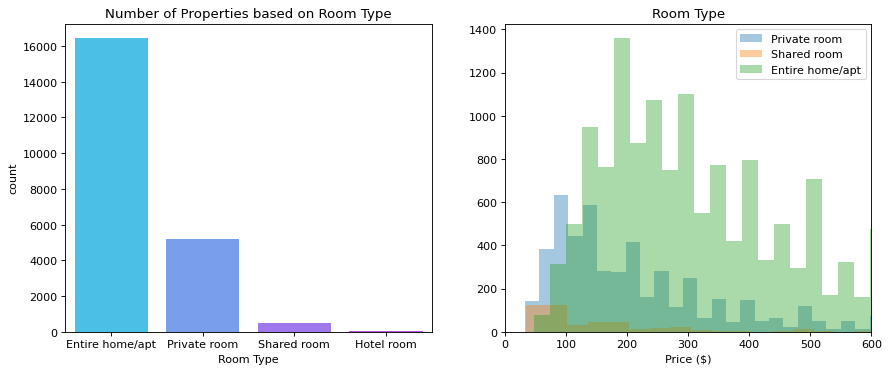

In [50]:
#Visualize the data to interpret the room_type and their mean price for each type
fig, axs = plt.subplots(1, 2, figsize=(13, 5), dpi=80)
sns.countplot(x = 'room_type', data = df_int, 
              palette = 'cool', ax=axs[0]).set_title("Number of Properties based on Room Type")
axs[0].set_xlabel('Room Type')


#Visualize and understand the distriution of pricing among the each room type.
sns.distplot(df_int[df_int.room_type == 'Private room']['price'],
             kde=False, ax=axs[1], label='Private room')
sns.distplot(df_int[df_int.room_type == 'Shared room']['price'],
             kde=False, ax=axs[1], label='Shared room')
sns.distplot(df_int[df_int.room_type == 'Entire home/apt']['price'],
             kde=False, ax=axs[1], label='Entire home/apt')

axs[1].set_xlim(0, 600);
axs[1].set_title('Room Type');
axs[1].set_xlabel('Price ($)');
axs[1].legend();

The Entire home/apt have the maximum number of entries in the Rio de Janeiro listings.

Checking at the price distribution of Entire home/apt, the maximum number of listings are between 100-300 R$(reais) .

The private rooms are maximum distributed between 50-150 R$(reais).

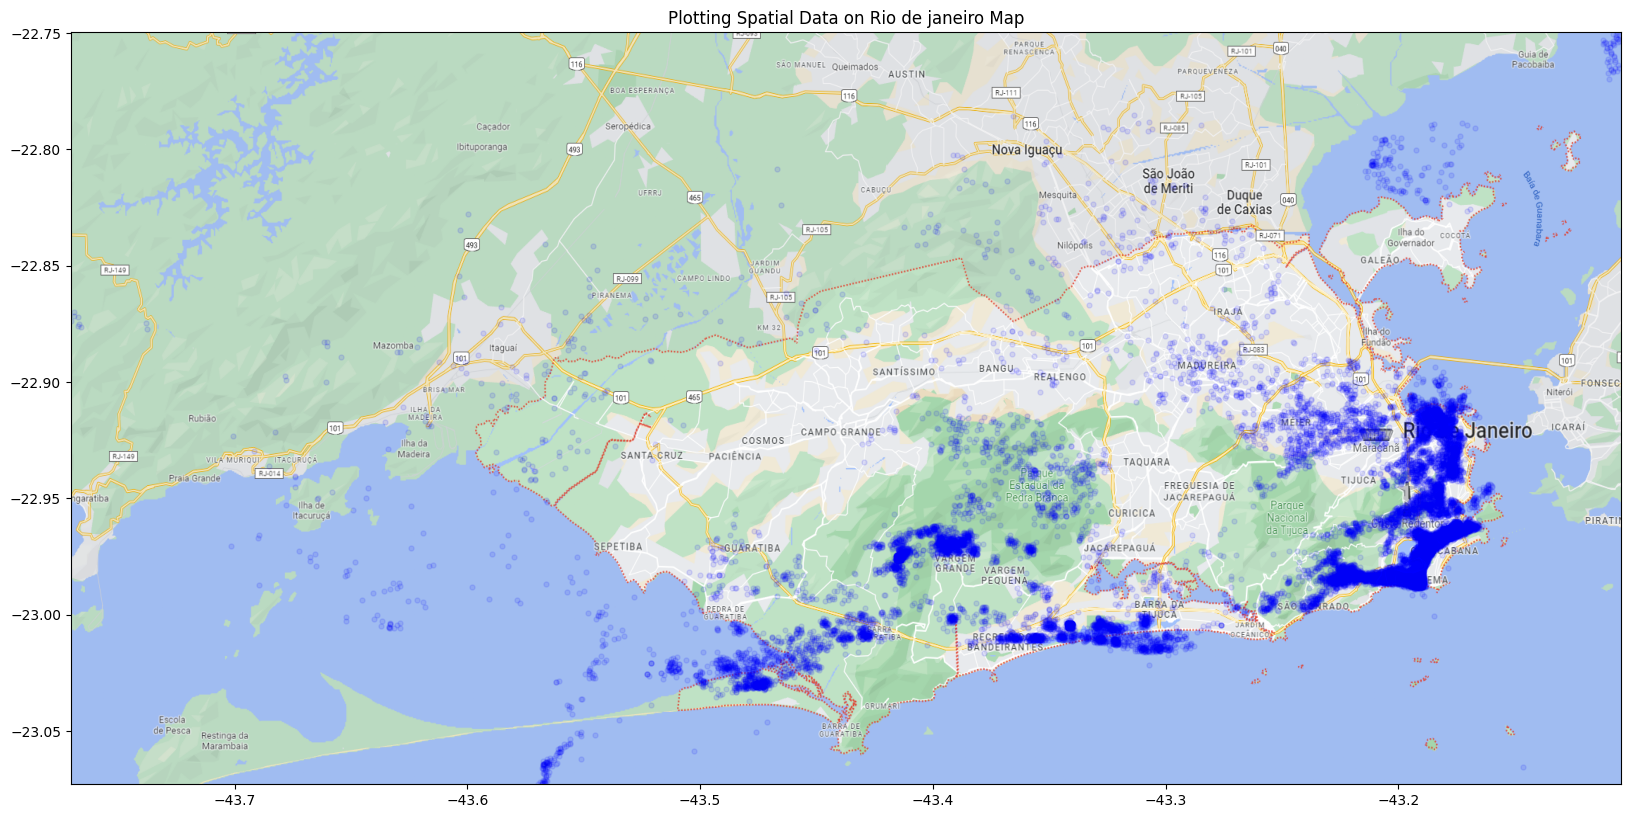

In [51]:
#Visualize the spatial data on Boston Map
BBox = (df_int.longitude.min(), df_int.longitude.max(), df_int.latitude.min(), df_int.latitude.max())
BBox

ruh_m = plt.imread('C:/Users/zanin/OneDrive/Área de Trabalho/airbnbrj/rio11.png')

fig, ax = plt.subplots(figsize = (20,15))
ax.scatter(df_int.longitude, df_int.latitude, zorder=1, alpha= 0.1, c='b', s=13)
ax.set_title('Plotting Spatial Data on Rio de janeiro Map')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')

Above we can see the approximated distribution of the of listings through the city of rio, as the city map shows a very dense number of listings are distribuited along the litoral in mojority. We can observe a highly populated
area on the neighbourhoods of copacabana, barra da tijuca, ipanema, jacarepaguá, recreio dos bandeirantes, leblon botafogo and so on, the center area have also high quantity of listings and close to tourist points as "cristo rendentor" and "maracana".


C:\Users\zanin\AppData\Local\Temp\ipykernel_18812\901890008.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_roomtype = df_int.groupby(['room_type', 'bedrooms'], as_index = False).mean()


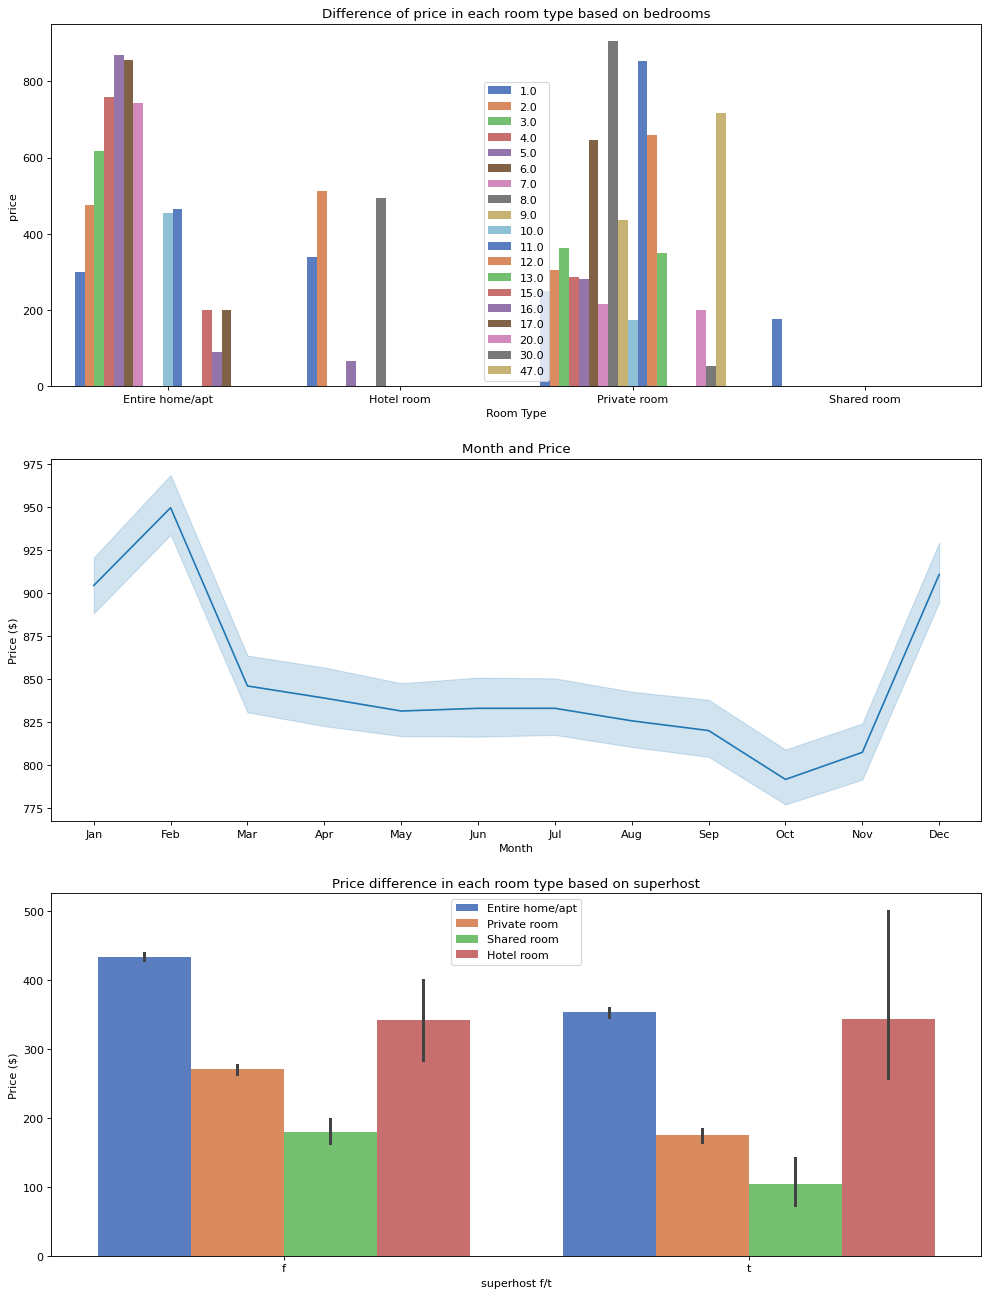

<Figure size 1000x500 with 0 Axes>

In [52]:
fig, axs = plt.subplots(3, 1, figsize=(15, 20), dpi=80)

df_roomtype = df_int.groupby(['room_type', 'bedrooms'], as_index = False).mean()


# Room type
sns.barplot(x="room_type", y="price", hue= 'bedrooms', data= df_roomtype, 
            palette= 'muted', ax=axs[0])

axs[0].set_title('Difference of price in each room type based on bedrooms')
axs[0].set_xlabel('Room Type')
axs[0].legend()


#calendar
cats = ['Jan', 'Feb', 'Mar', 'Apr','May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df_cal['month'] = pd.Categorical(df_cal['month'], ordered=True, categories=cats)

plt.figure(figsize=(10,5))

sns.lineplot(data = df_cal, x = "month", y = "price", sort=True, ax = axs[1])

axs[1].set_title("Month and Price")
axs[1].set_xlabel('Month')
axs[1].set_ylabel('Price ($)')


#Superhost
sns.barplot(x="superhost", y="price", hue= 'room_type', data= df_int, 
            palette= 'muted', ax=axs[2])

axs[2].set_title('Price difference in each room type based on superhost')
axs[2].set_xlabel('superhost f/t')
axs[2].set_ylabel('Price ($)')
axs[2].legend()


plt.tight_layout()
plt.show();

As we can see on the first barchart the listing prices are directly co-related with rooms types and also with the bedrooms available, we see that the price increse relatively with an increse in the number of bedrooms. if we take a look on chart 'Difference of price in each room type based on bedrooms'is possible see that Entire home/apartment is really expensive in Rio de Janeiro, on this dataset.

As we can see in the online graph, the price appears to have increased significantly from November onwards, and remains high throughout the end of the year, including Christmas and New Year, which are culturally celebrated dates in Brazil, but it only reaches its peak in February, month in which carnival usually takes place, the biggest and most famous Brazilian party where everyone dresses up and celebrates throughout the month, bringing together more than 4 million people, and almost 500 thousand foreigners, which evidently causes a great demand for accommodation in the city.

The "Price Difference in Each Room Type Based on Superhost" chart again shows a similarity in high prices for the entire home/apt, while another insight we can draw is that Superhosted properties are generally lower than properties with normal hosts, both in whole houses and in all types of accommodation, this seems strange but we have to take into account that the offer of regular hosts is many times greater and that there are some outliers that can affect the chart.

**WHAT IS THE MOST EXPANSIVE NEIGHBOURHOOD IN RIO DE JANEIRO?**

In [53]:
neighbourhoods = df.groupby('neighbourhood_cleansed').agg(
    {
        'price': np.mean
    }
).reset_index()

neighbourhoods.head(156).sort_values(by= 'price', ascending=False)

,neighbourhood_cleansed,price
18,Caju,1033.000000
114,Ricardo de Albuquerque,943.666667
33,Complexo do Alemão,900.000000
3,Anchieta,800.000000
55,Grumari,673.800000
...,...,...
71,Jardim Carioca,84.000000
43,Engenho da Rainha,79.000000
113,Ribeira,76.500000
136,Tomás Coelho,75.000000


<AxesSubplot: xlabel='price', ylabel='neighbourhood_cleansed'>

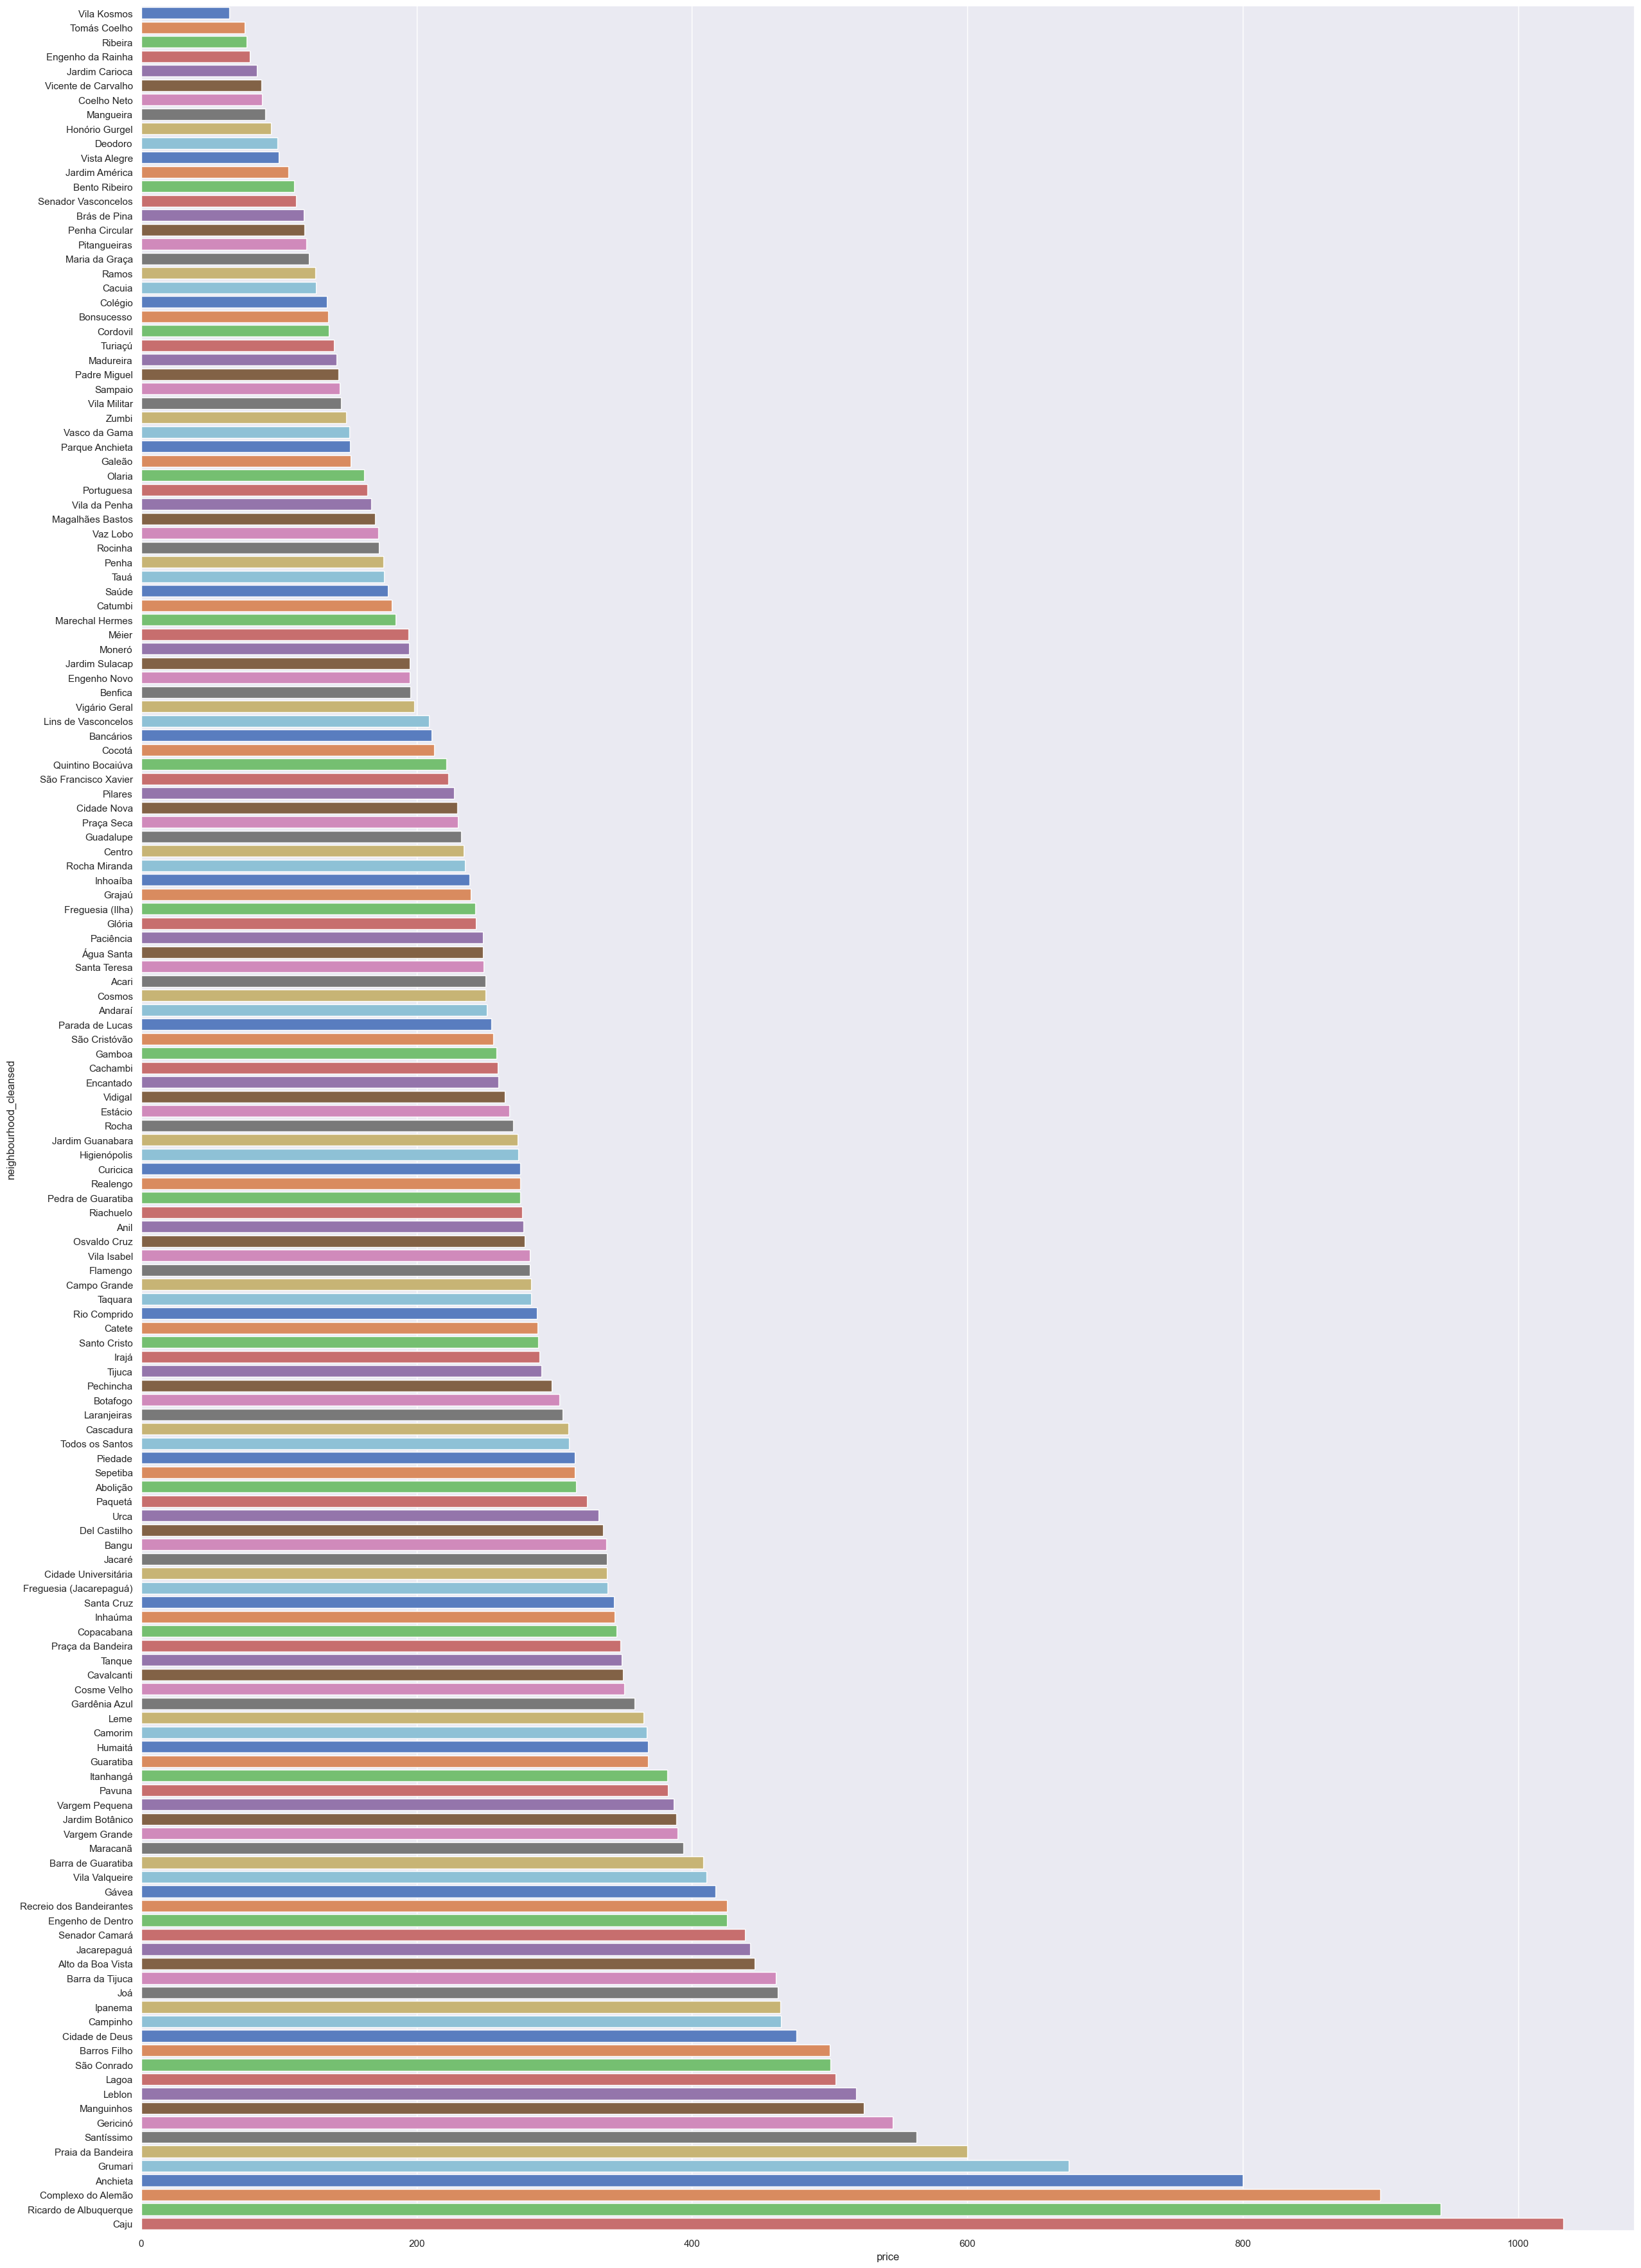

In [54]:
sns.set(rc={'figure.figsize':(30,45)})
# Neighbourhoods
neighbourhoods = df.groupby('neighbourhood_cleansed').agg(
    {
        'price': np.mean
    }
).reset_index()
sns.barplot(
    x='price', y='neighbourhood_cleansed',
    data=neighbourhoods.sort_values('price'),
    orient='h',
    palette='muted'
)